In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import torch
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings
from scipy.integrate import odeint
from matplotlib import style
import torch.nn as nn
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')

np.random.seed(1234)

# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
cls = pd.read_pickle("A2Q1_data.pkl")

X_train_cls = torch.tensor(cls["X_train"].astype(float).values).float().to(device)
X_test_cls  = torch.tensor(cls["X_test"].astype(float).values).float().to(device)

y_train_cls = torch.tensor(cls["y_train"].values).float().to(device).reshape(-1, 1)
y_test_cls  = torch.tensor(cls["y_test"].values).float().to(device).reshape(-1, 1)

reg = pd.read_pickle("A2Q1_data_regression.pkl")

X_train_reg = torch.tensor(reg["X_train"].astype(float).values).float().to(device)
X_test_reg  = torch.tensor(reg["X_test"].astype(float).values).float().to(device)

y_train_reg = torch.tensor(reg["y_train"].values).float().to(device).reshape(-1, 1)
y_test_reg  = torch.tensor(reg["y_test"].values).float().to(device).reshape(-1, 1)

### Q1.1

In [3]:

def classification_metrics_from_probs(probs: torch.Tensor, y_true: torch.Tensor, threshold: float = 0.5):
    preds = (probs >= threshold).float()

    tp = ((preds == 1) & (y_true == 1)).sum().item()
    tn = ((preds == 0) & (y_true == 0)).sum().item()
    fp = ((preds == 1) & (y_true == 0)).sum().item()
    fn = ((preds == 0) & (y_true == 1)).sum().item()

    n = y_true.numel()
    acc = (tp + tn) / n if n > 0 else float("nan")
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return acc, prec, rec

def mse_metric(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    return torch.mean((y_pred - y_true) ** 2).item()


class DNN(torch.nn.Module):
    def __init__(self, layers, min_val, max_val):
        super(DNN, self).__init__()

        self.depth = len(layers) - 1

        self.min_val = torch.tensor(min_val, requires_grad=False).float().to(device)
        self.max_val = torch.tensor(max_val, requires_grad=False).float().to(device)

        self.activation = torch.nn.Tanh

        layer_list = []
        for i in range(self.depth - 1):
            layer_list.append(("layer_%d" % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(("activation_%d" % i, self.activation()))
        layer_list.append(("layer_%d" % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))

        self.layers = torch.nn.Sequential(OrderedDict(layer_list))

    def forward(self, x):
        res = (x - self.min_val) / (self.max_val - self.min_val + 1e-12)
        return self.layers(res)


class DefaultClassifierNN:
    def __init__(self, X_train, y_train, layers):
        self.X_train = X_train
        self.y_train = y_train

        Xmin = X_train.min(dim=0, keepdim=True).values
        Xmax = X_train.max(dim=0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax).to(device)

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.sigmoid = torch.nn.Sigmoid()
        self.criterion = torch.nn.BCELoss()

    def forward_probs(self, X):
        logits = self.dnn(X)
        return self.sigmoid(logits)

    def train(self, adam_epochs=500):
        self.dnn.train()
        for _ in range(adam_epochs):
            probs = self.forward_probs(self.X_train)
            loss = self.criterion(probs, self.y_train)

            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

    def predict_probs(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.forward_probs(X)

class DefaultRegressorNN:
    def __init__(self, X_train, y_train, layers):
        self.X_train = X_train
        self.y_train = y_train

        Xmin = X_train.min(dim=0, keepdim=True).values
        Xmax = X_train.max(dim=0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax).to(device)

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.criterion = torch.nn.MSELoss()

    def train(self, adam_epochs=500):
        self.dnn.train()
        for _ in range(adam_epochs):
            pred = self.dnn(self.X_train)
            loss = self.criterion(pred, self.y_train)

            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

    def predict(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.dnn(X)


def report_classifier_q11(X_train, y_train, X_test, y_test, layers, epochs=500, n_splits=5):
    print("\n========== CLASSIFICATION REPORT (Q1.1) ==========")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1234)
    cv_acc, cv_prec, cv_rec = [], [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_va, y_va = X_train[va_idx], y_train[va_idx]

        model = DefaultClassifierNN(X_tr, y_tr, layers)
        model.train(adam_epochs=epochs)

        probs_va = model.predict_probs(X_va)
        acc, prec, rec = classification_metrics_from_probs(probs_va, y_va)
        cv_acc.append(acc); cv_prec.append(prec); cv_rec.append(rec)

        print(f"[CLS CV] Fold {fold}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}")

    print(f"[CLS CV] Mean Acc ={np.mean(cv_acc):.4f}")
    print(f"[CLS CV] Mean Prec={np.mean(cv_prec):.4f}")
    print(f"[CLS CV] Mean Rec ={np.mean(cv_rec):.4f}")

    full_model = DefaultClassifierNN(X_train, y_train, layers)
    full_model.train(adam_epochs=epochs)

    probs_train = full_model.predict_probs(X_train)
    probs_test  = full_model.predict_probs(X_test)

    train_acc, train_prec, train_rec = classification_metrics_from_probs(probs_train, y_train)
    test_acc,  test_prec,  test_rec  = classification_metrics_from_probs(probs_test,  y_test)

    print(f"[CLS FULL] Train: Acc={train_acc:.4f}, Prec={train_prec:.4f}, Rec={train_rec:.4f}")
    print(f"[CLS FULL] Test : Acc={test_acc:.4f},  Prec={test_prec:.4f},  Rec={test_rec:.4f}")

def report_regressor_q11(X_train, y_train, X_test, y_test, layers, epochs=500, n_splits=5):
    print("\n========== REGRESSION REPORT (Q1.1) ==========")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1234)
    cv_mse = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_va, y_va = X_train[va_idx], y_train[va_idx]

        model = DefaultRegressorNN(X_tr, y_tr, layers)
        model.train(adam_epochs=epochs)

        pred_va = model.predict(X_va)
        mse = mse_metric(pred_va, y_va)
        cv_mse.append(mse)

        print(f"[REG CV] Fold {fold}: Val MSE={mse:.6f}")

    print(f"[REG CV] Mean Val MSE={np.mean(cv_mse):.6f}")

    full_model = DefaultRegressorNN(X_train, y_train, layers)
    full_model.train(adam_epochs=epochs)

    pred_train = full_model.predict(X_train)
    pred_test  = full_model.predict(X_test)

    train_mse = mse_metric(pred_train, y_train)
    test_mse  = mse_metric(pred_test,  y_test)

    print(f"[REG FULL] Train MSE={train_mse:.6f}")
    print(f"[REG FULL] Test  MSE={test_mse:.6f}")



cls_layers = [X_train_cls.shape[1], 64, 32, 1]
reg_layers = [X_train_reg.shape[1], 64, 32, 1]

EPOCHS = 500
KFOLDS = 5

report_classifier_q11(X_train_cls, y_train_cls, X_test_cls, y_test_cls, cls_layers, epochs=EPOCHS, n_splits=KFOLDS)
report_regressor_q11(X_train_reg, y_train_reg, X_test_reg, y_test_reg, reg_layers, epochs=EPOCHS, n_splits=KFOLDS)


========== CLASSIFICATION REPORT (Q1.1) ==========
[CLS CV] Fold 1: Acc=0.6333, Prec=0.3333, Rec=0.2222
[CLS CV] Fold 2: Acc=0.6000, Prec=0.2727, Rec=0.1579
[CLS CV] Fold 3: Acc=0.6167, Prec=0.4545, Rec=0.2273
[CLS CV] Fold 4: Acc=0.5833, Prec=0.4000, Rec=0.2727
[CLS CV] Fold 5: Acc=0.5667, Prec=0.2500, Rec=0.3125
[CLS CV] Mean Acc =0.6000
[CLS CV] Mean Prec=0.3421
[CLS CV] Mean Rec =0.2385
[CLS FULL] Train: Acc=0.7700, Prec=0.7188, Rec=0.4742
[CLS FULL] Test : Acc=0.5926,  Prec=0.3333,  Rec=0.2222

========== REGRESSION REPORT (Q1.1) ==========
[REG CV] Fold 1: Val MSE=3616.625000
[REG CV] Fold 2: Val MSE=3520.021240
[REG CV] Fold 3: Val MSE=3560.945801
[REG CV] Fold 4: Val MSE=3389.607910
[REG CV] Fold 5: Val MSE=3649.783691
[REG CV] Mean Val MSE=3547.396729
[REG FULL] Train MSE=3560.229980
[REG FULL] Test  MSE=3790.144775


### Q1.2 Testing different activation functions

In [4]:
class DNN(torch.nn.Module):
    def __init__(self, layers, min_val, max_val, activation_mode="tanh"):
        super(DNN, self).__init__()

        self.depth = len(layers) - 1
        self.min_val = torch.tensor(min_val, requires_grad=False).float().to(device)
        self.max_val = torch.tensor(max_val, requires_grad=False).float().to(device)

        def act_for_hidden(i):
            if activation_mode == "tanh":
                return torch.nn.Tanh()
            if activation_mode == "relu":
                return torch.nn.ReLU()
            if activation_mode == "mixed":
                return torch.nn.ReLU() if (i % 2 == 0) else torch.nn.Tanh()

        layer_list = []
        for i in range(self.depth - 1):
            layer_list.append(("layer_%d" % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(("activation_%d" % i, act_for_hidden(i)))
        layer_list.append(("layer_%d" % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))

        self.layers = torch.nn.Sequential(OrderedDict(layer_list))

    def forward(self, x):
        res = (x - self.min_val) / (self.max_val - self.min_val + 1e-12)
        return self.layers(res)


class ClassifierNN:
    def __init__(self, X_train, y_train, layers, activation_mode="tanh"):
        self.X_train = X_train
        self.y_train = y_train

        Xmin = X_train.min(dim=0, keepdim=True).values
        Xmax = X_train.max(dim=0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax, activation_mode=activation_mode).to(device)

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.sigmoid = torch.nn.Sigmoid()
        self.criterion = torch.nn.BCELoss()

    def forward_probs(self, X):
        logits = self.dnn(X)
        return self.sigmoid(logits)

    def train(self, adam_epochs=500):
        self.dnn.train()
        for _ in range(adam_epochs):
            probs = self.forward_probs(self.X_train)
            loss = self.criterion(probs, self.y_train)
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

    def predict_probs(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.forward_probs(X)

class RegressorNN:
    def __init__(self, X_train, y_train, layers, activation_mode="tanh"):
        self.X_train = X_train
        self.y_train = y_train

        Xmin = X_train.min(dim=0, keepdim=True).values
        Xmax = X_train.max(dim=0, keepdim=True).values

        self.dnn = DNN(layers, Xmin, Xmax, activation_mode=activation_mode).to(device)

        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.criterion = torch.nn.MSELoss()

    def train(self, adam_epochs=500):
        self.dnn.train()
        for _ in range(adam_epochs):
            pred = self.dnn(self.X_train)
            loss = self.criterion(pred, self.y_train)
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

    def predict(self, X):
        self.dnn.eval()
        with torch.no_grad():
            return self.dnn(X)


def evaluate_classifier_cv_and_test(X_train, y_train, X_test, y_test, layers, activation_mode, epochs=500, k=5):
    print(f"\n--- Classification | activation={activation_mode} ---")

    kf = KFold(n_splits=k, shuffle=True, random_state=1234)
    accs, precs, recs = [], [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_va, y_va = X_train[va_idx], y_train[va_idx]

        m = ClassifierNN(X_tr, y_tr, layers, activation_mode=activation_mode)
        m.train(adam_epochs=epochs)

        probs_va = m.predict_probs(X_va)
        acc, prec, rec = classification_metrics_from_probs(probs_va, y_va)

        accs.append(acc); precs.append(prec); recs.append(rec)
        print(f"[CLS CV] Fold {fold}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}")

    print(f"[CLS CV] Mean Acc ={np.mean(accs):.4f}")
    print(f"[CLS CV] Mean Prec={np.mean(precs):.4f}")
    print(f"[CLS CV] Mean Rec ={np.mean(recs):.4f}")

    m_full = ClassifierNN(X_train, y_train, layers, activation_mode=activation_mode)
    m_full.train(adam_epochs=epochs)

    probs_train = m_full.predict_probs(X_train)
    probs_test  = m_full.predict_probs(X_test)

    tr_acc, tr_prec, tr_rec = classification_metrics_from_probs(probs_train, y_train)
    te_acc, te_prec, te_rec = classification_metrics_from_probs(probs_test,  y_test)

    print(f"[CLS FULL] Train: Acc={tr_acc:.4f}, Prec={tr_prec:.4f}, Rec={tr_rec:.4f}")
    print(f"[CLS FULL] Test : Acc={te_acc:.4f},  Prec={te_prec:.4f},  Rec={te_rec:.4f}")

    return {
        "cv_acc_mean": float(np.mean(accs)),
        "cv_prec_mean": float(np.mean(precs)),
        "cv_rec_mean": float(np.mean(recs)),
        "test_acc": te_acc,
        "test_prec": te_prec,
        "test_rec": te_rec,
    }

def evaluate_regressor_cv_and_test(X_train, y_train, X_test, y_test, layers, activation_mode, epochs=500, k=5):
    print(f"\n--- Regression | activation={activation_mode} ---")

    kf = KFold(n_splits=k, shuffle=True, random_state=1234)
    mses = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train), start=1):
        X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
        X_va, y_va = X_train[va_idx], y_train[va_idx]

        m = RegressorNN(X_tr, y_tr, layers, activation_mode=activation_mode)
        m.train(adam_epochs=epochs)

        pred_va = m.predict(X_va)
        mse = mse_metric(pred_va, y_va)
        mses.append(mse)
        print(f"[REG CV] Fold {fold}: Val MSE={mse:.6f}")

    print(f"[REG CV] Mean Val MSE={np.mean(mses):.6f}")

    m_full = RegressorNN(X_train, y_train, layers, activation_mode=activation_mode)
    m_full.train(adam_epochs=epochs)

    pred_train = m_full.predict(X_train)
    pred_test  = m_full.predict(X_test)

    tr_mse = mse_metric(pred_train, y_train)
    te_mse = mse_metric(pred_test,  y_test)

    print(f"[REG FULL] Train MSE={tr_mse:.6f}")
    print(f"[REG FULL] Test  MSE={te_mse:.6f}")

    return {
        "cv_mse_mean": float(np.mean(mses)),
        "test_mse": te_mse,
    }

print("\n========== ACTIVATION COMPARISON: CLASSIFICATION ==========")
cls_summaries = {}
for act in ["relu", "tanh", "mixed"]:
    cls_summaries[act] = evaluate_classifier_cv_and_test(
        X_train_cls, y_train_cls, X_test_cls, y_test_cls,
        cls_layers, activation_mode=act, epochs=EPOCHS, k=KFOLDS
    )

print("\n========== ACTIVATION COMPARISON: REGRESSION ==========")
reg_summaries = {}
for act in ["relu", "tanh", "mixed"]:
    reg_summaries[act] = evaluate_regressor_cv_and_test(
        X_train_reg, y_train_reg, X_test_reg, y_test_reg,
        reg_layers, activation_mode=act, epochs=EPOCHS, k=KFOLDS
    )



========== ACTIVATION COMPARISON: CLASSIFICATION ==========

--- Classification | activation=relu ---
[CLS CV] Fold 1: Acc=0.6500, Prec=0.4000, Rec=0.3333
[CLS CV] Fold 2: Acc=0.5333, Prec=0.2632, Rec=0.2632
[CLS CV] Fold 3: Acc=0.5667, Prec=0.3571, Rec=0.2273
[CLS CV] Fold 4: Acc=0.5667, Prec=0.3750, Rec=0.2727
[CLS CV] Fold 5: Acc=0.5333, Prec=0.2500, Rec=0.3750
[CLS CV] Mean Acc =0.5700
[CLS CV] Mean Prec=0.3291
[CLS CV] Mean Rec =0.2943
[CLS FULL] Train: Acc=0.7933, Prec=0.7465, Rec=0.5464
[CLS FULL] Test : Acc=0.6296,  Prec=0.4286,  Rec=0.3333

--- Classification | activation=tanh ---
[CLS CV] Fold 1: Acc=0.6500, Prec=0.3636, Rec=0.2222
[CLS CV] Fold 2: Acc=0.6167, Prec=0.3333, Rec=0.2105
[CLS CV] Fold 3: Acc=0.5500, Prec=0.3077, Rec=0.1818
[CLS CV] Fold 4: Acc=0.6000, Prec=0.4375, Rec=0.3182
[CLS CV] Fold 5: Acc=0.6167, Prec=0.2941, Rec=0.3125
[CLS CV] Mean Acc =0.6067
[CLS CV] Mean Prec=0.3473
[CLS CV] Mean Rec =0.2490
[CLS FULL] Train: Acc=0.7600, Prec=0.6866, Rec=0.4742
[CLS 

Based on the results, ReLU performs best for regression model because it has the lowest test MSE.  

For classification model, tanh performs the best because it has the highest Accuracy, Precision. (Recall remains low for all models.)


### Q1.3 Learning rate and momentum


=== CV RESULTS ===
learning rate=0.1, momentum=0.0 | Acc=0.657 Prec=0.323 Rec=0.078 | MSE=nan
learning rate=0.1, momentum=0.9 | Acc=0.633 Prec=0.419 Rec=0.246 | MSE=nan
learning rate=0.01, momentum=0.0 | Acc=0.677 Prec=0.000 Rec=0.000 | MSE=271.52
learning rate=0.01, momentum=0.9 | Acc=0.650 Prec=0.290 Rec=0.068 | MSE=271.63

Best classification: (0.1, 0.9)
Best regression: (0.01, 0.0)

Classification FULL
Train: (0.7366666666666667, 0.6875, 0.3402061855670103)
Test : (0.5925925925925926, 0.16666666666666666, 0.05555555555555555)

Regression FULL
Train MSE: 439.2034912109375
Test  MSE: 333.7809143066406


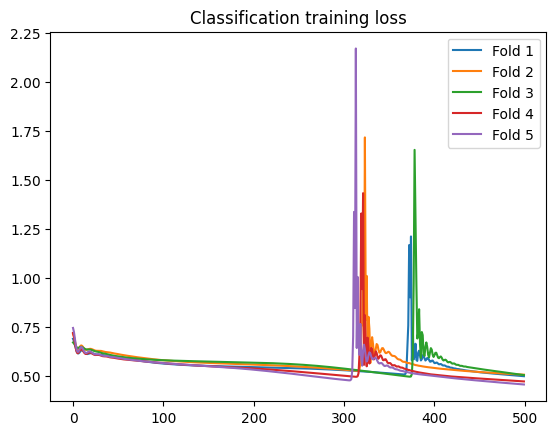

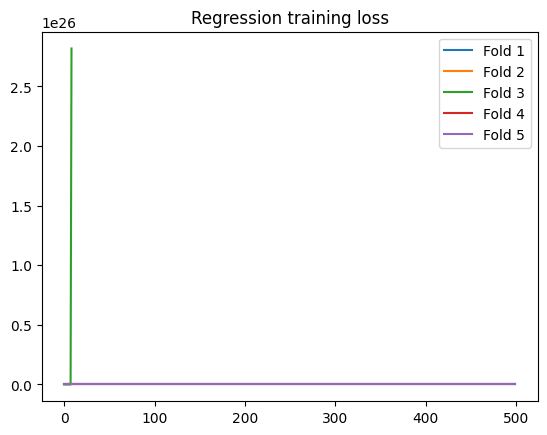

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 500
KFOLDS = 5

def classification_metrics(probs, y):
    preds = (probs >= 0.5).float()

    tp = ((preds == 1) & (y == 1)).sum().item()
    tn = ((preds == 0) & (y == 0)).sum().item()
    fp = ((preds == 1) & (y == 0)).sum().item()
    fn = ((preds == 0) & (y == 1)).sum().item()

    acc = (tp + tn) / y.numel()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0

    return acc, prec, rec

def mse(pred, y):
    return torch.mean((pred - y)**2).item()

class DNN(nn.Module):
    def __init__(self, layers, min_val, max_val, activation="tanh"):
        super().__init__()

        self.min_val = min_val
        self.max_val = max_val

        def act():
            if activation == "tanh":
                return nn.Tanh()
            return nn.ReLU()

        layer_list = []
        for i in range(len(layers)-2):
            layer_list.append(("l"+str(i), nn.Linear(layers[i], layers[i+1])))
            layer_list.append(("a"+str(i), act()))
        layer_list.append(("out", nn.Linear(layers[-2], layers[-1])))

        self.net = nn.Sequential(OrderedDict(layer_list))

    def forward(self, x):
        x = (x - self.min_val)/(self.max_val-self.min_val+1e-12)
        return self.net(x)

class Classifier:
    def __init__(self, X, y, layers, lr, momentum):
        self.X = X
        self.y = y

        Xmin = X.min(0, keepdim=True).values
        Xmax = X.max(0, keepdim=True).values

        self.model = DNN(layers, Xmin, Xmax, activation="tanh").to(device)
        self.sig = nn.Sigmoid()
        self.loss_fn = nn.BCELoss()

        self.opt = torch.optim.SGD(
            self.model.parameters(),
            lr=lr,
            momentum=momentum
        )

        self.loss_history = []

    def train(self):
        self.model.train()
        self.loss_history = []

        for _ in range(EPOCHS):
            p = self.sig(self.model(self.X))
            loss = self.loss_fn(p, self.y)

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

            self.loss_history.append(loss.item())

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.sig(self.model(X))

class Regressor:
    def __init__(self, X, y, layers, lr, momentum):
        self.X = X
        self.y = y

        Xmin = X.min(0, keepdim=True).values
        Xmax = X.max(0, keepdim=True).values

        self.model = DNN(layers, Xmin, Xmax, activation="relu").to(device)
        self.loss_fn = nn.MSELoss()

        self.opt = torch.optim.SGD(
            self.model.parameters(),
            lr=lr,
            momentum=momentum
        )

        self.loss_history = []

    def train(self):
        self.model.train()
        self.loss_history = []

        for _ in range(EPOCHS):
            pred = self.model(self.X)
            loss = self.loss_fn(pred, self.y)

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

            self.loss_history.append(loss.item())

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.model(X)
        
cls = pd.read_pickle("A2Q1_data.pkl")
X_train_cls = torch.tensor(cls["X_train"].astype(float).values).float().to(device)
X_test_cls  = torch.tensor(cls["X_test"].astype(float).values).float().to(device)
y_train_cls = torch.tensor(cls["y_train"].values).float().reshape(-1,1).to(device)
y_test_cls  = torch.tensor(cls["y_test"].values).float().reshape(-1,1).to(device)

reg = pd.read_pickle("A2Q1_data_regression.pkl")
X_train_reg = torch.tensor(reg["X_train"].astype(float).values).float().to(device)
X_test_reg  = torch.tensor(reg["X_test"].astype(float).values).float().to(device)
y_train_reg = torch.tensor(reg["y_train"].values).float().reshape(-1,1).to(device)
y_test_reg  = torch.tensor(reg["y_test"].values).float().reshape(-1,1).to(device)

cls_layers = [X_train_cls.shape[1], 64, 32, 1]
reg_layers = [X_train_reg.shape[1], 64, 32, 1]

lrs = [0.1, 0.01]
momentums = [0.0, 0.9]

print("\n=== CV RESULTS ===")

best_cls = None
best_reg = None
best_acc = -1
best_mse = 1e12
best_score = -1

for lr in lrs:
    for m in momentums:

        kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=0)

        accs, precs, recs = [], [], []
        mses = []

        for tr, val in kf.split(X_train_cls):

            # classification
            clf = Classifier(X_train_cls[tr], y_train_cls[tr], cls_layers, lr, m)
            clf.train()
            p = clf.predict(X_train_cls[val])
            acc, prec, rec = classification_metrics(p, y_train_cls[val])
            accs.append(acc); precs.append(prec); recs.append(rec)

            # regression
            regm = Regressor(X_train_reg[tr], y_train_reg[tr], reg_layers, lr, m)
            regm.train()
            pred = regm.predict(X_train_reg[val])
            mses.append(mse(pred, y_train_reg[val]))

        acc_mean = np.mean(accs)
        mse_mean = np.mean(mses)

        print(f"learning rate={lr}, momentum={m} | Acc={acc_mean:.3f} Prec={np.mean(precs):.3f} Rec={np.mean(recs):.3f} | MSE={mse_mean:.2f}")

        score = np.mean(precs) + np.mean(recs)
        if score > best_score:
            best_score = score
            best_cls = (lr, m)

        if mse_mean < best_mse:
            best_mse = mse_mean
            best_reg = (lr, m)

print("\nBest classification:", best_cls)
print("Best regression:", best_reg)

lr, m = best_cls
clf = Classifier(X_train_cls, y_train_cls, cls_layers, lr, m)
clf.train()

p_train = clf.predict(X_train_cls)
p_test  = clf.predict(X_test_cls)

print("\nClassification FULL")
print("Train:", classification_metrics(p_train, y_train_cls))
print("Test :", classification_metrics(p_test, y_test_cls))

lr, m = best_reg
regm = Regressor(X_train_reg, y_train_reg, reg_layers, lr, m)
regm.train()

print("\nRegression FULL")
print("Train MSE:", mse(regm.predict(X_train_reg), y_train_reg))
print("Test  MSE:", mse(regm.predict(X_test_reg),  y_test_reg))

plt.figure()
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=0)
fold = 1
for tr, _ in kf.split(X_train_cls):
    clf = Classifier(X_train_cls[tr], y_train_cls[tr], cls_layers, best_cls[0], best_cls[1])
    clf.train()
    plt.plot(clf.loss_history, label=f"Fold {fold}")
    fold += 1
plt.title("Classification training loss")
plt.legend()
plt.show()

plt.figure()
fold = 1
for tr, _ in kf.split(X_train_reg):
    regm = Regressor(X_train_reg[tr], y_train_reg[tr], reg_layers, best_reg[0], best_reg[1])
    regm.train()
    plt.plot(regm.loss_history, label=f"Fold {fold}")
    fold += 1
plt.title("Regression training loss")
plt.legend()
plt.show()